In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format', '{:.4f}'.format)
%precision 4
plt.rcParams['figure.dpi'] = 150

In [3]:
import yfinance as yf
import requests_cache
session = requests_cache.CachedSession(expire_after='1D')

# Calculate daily returns for the S&P 100 stocks.

In [4]:
returns = pd.read_html("https://en.wikipedia.org/wiki/S%26P_100#Components")[2]

In [5]:
ticker = list(returns.loc[:, "Symbol"])

for i in range(len(ticker)):
    ticker[i] = ticker[i].replace('.', '-')

In [6]:
def download(**kwargs):
    _stocks = yf.download(**kwargs)
    _returns = _stocks["Adj Close"].pct_change()
    _multi_index = pd.MultiIndex.from_product([["Returns"],_stocks["Adj Close"].columns])
    _stocks[_multi_index] = _returns
    return _stocks

In [7]:
df = download(tickers = ticker, session = session).stack().swaplevel().sort_index()

[*********************100%***********************]  101 of 101 completed


/tmp/ipykernel_18069/3013159967.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _stocks[_multi_index] = _returns


In [8]:
returns_daily = pd.DataFrame(df.loc[:,"Returns"]).unstack().unstack().unstack().swaplevel().loc['2020-01-01':'2022-08-31'].swaplevel().unstack().unstack().unstack()
returns_daily

Returns
     Date               
AAPL 2020-01-02   0.0228
     2020-01-03  -0.0097
     2020-01-06   0.0080
     2020-01-07  -0.0047
     2020-01-08   0.0161
...                  ...
XOM  2022-08-25   0.0052
     2022-08-26  -0.0123
     2022-08-29   0.0230
     2022-08-30  -0.0381
     2022-08-31  -0.0075

[67872 rows x 1 columns]

# How well do annualized average returns in 2020 predict those in 2021?

In [9]:
print("The annualized average returns in 2020 do not predict those in 2021 very well. The differences between both years can not only be significant, but are not consistent between the different stocks. Some returns are half as small in 2021 compared to 2020, while some stay relatively the same.")
unstack_2020 = returns_daily.unstack().unstack().unstack().swaplevel().loc['2020-01-01':'2020-12-31']
unstack_2021 = returns_daily.unstack().unstack().unstack().swaplevel().loc['2021-01-01':'2021-12-31']
unstack_all = returns_daily.unstack().unstack().unstack().swaplevel()

returns_2020 = pd.DataFrame(unstack_2020.mean().mul(252))
returns_2021 = pd.DataFrame(unstack_2021.mean().mul(252))

returns_2020.columns = ['Annualized Average Returns for 2020']
returns_2021.columns = ['Annualized Average Returns for 2021']

pd.concat([returns_2020,returns_2021], axis = 1)



The annualized average returns in 2020 do not predict those in 2021 very well. The differences between both years can not only be significant, but are not consistent between the different stocks. Some returns are half as small in 2021 compared to 2020, while some stay relatively the same.


,Annualized Average Returns for 2020,Annualized Average Returns for 2021
AAPL,0.7073,0.3290
ABBV,0.3048,0.3014
ABT,0.3226,0.2892
ACN,0.3166,0.4939
ADBE,0.5290,0.1692
...,...,...
VZ,0.0285,-0.0684
WBA,-0.2294,0.3441
WFC,-0.3488,0.5340
WMT,0.2576,0.0335


# How well do annualized standard deviations of returns in 2020 predict those in 2021?

In [10]:
print("Similar to the annualized average returns, annualized standard deviations of returns in 2020 do not predict those in 2021 very well. The differences between both years are significant throughout all the stocks.")
sd_2020 = pd.DataFrame(unstack_2020.std().mul(np.sqrt(252)))
sd_2021 = pd.DataFrame(unstack_2021.std().mul(np.sqrt(252)))

sd_2020.columns = ['Annualized Standard Deviations for 2020']
sd_2021.columns = ['Annualized Standard Deviations for 2021']

pd.concat([sd_2020,sd_2021], axis = 1)

Similar to the annualized average returns, annualized standard deviations of returns in 2020 do not predict those in 2021 very well. The differences between both years are significant throughout all the stocks.


,Annualized Standard Deviations for 2020,Annualized Standard Deviations for 2021
AAPL,0.4665,0.2510
ABBV,0.3488,0.2013
ABT,0.3922,0.2119
ACN,0.4171,0.1973
ADBE,0.4791,0.2934
...,...,...
VZ,0.2455,0.1427
WBA,0.4841,0.2769
WFC,0.6124,0.3365
WMT,0.3150,0.1672


# What are the mean, median, minimum, and maximum pairwise correlations between two stocks?

In [11]:
corr = unstack_all.corr()
corr2 = unstack_all.corr()
np.fill_diagonal(corr2.values, np.nan)

In [12]:
corr3 = corr.agg(["mean", "median", "min"]).unstack().unstack()
corr4 = corr2.agg(["max"]).unstack().unstack()
corr3["max"] = corr4["max"]

In [13]:
corr3

,mean,median,min,max
AAPL,0.5066,0.4855,0.3163,0.8098
ABBV,0.4277,0.4376,0.1798,0.6237
ABT,0.4739,0.4658,0.1880,0.7007
ACN,0.5762,0.5825,0.3653,0.7413
ADBE,0.4583,0.4382,0.1914,0.8310
...,...,...,...,...
VZ,0.4312,0.4398,0.0601,0.7176
WBA,0.4089,0.4013,0.1222,0.6777
WFC,0.5274,0.5148,0.1633,0.8797
WMT,0.3341,0.3189,0.1054,0.6551


In [14]:
print("The two lowest outliers for the correlations are between Verizon and Tesla. These companies are very different in both product and in volatility. Verizon is a steady electric telephone company, while Tesla is an electric car company that is constantly in the news. The next two lowest correlations, the Simon Property Group and Thermo Fisher Scientific, are very different in the service they provide. Simon Property Group is a real estate investment trust, where as Thermo Fisher Scientific actually supplies products. The third lowest correlations are also between companies that serve very different demographics. Altria Group is a tobacco company that serves an older demographic, while Netflix is an entertainment company that serves a younger demographic.")
outliers_min = corr3.sort_values("min").head(6)
outliers_min[["min"]]

The two lowest outliers for the correlations are between Verizon and Tesla. These companies are very different in both product and in volatility. Verizon is a steady electric telephone company, while Tesla is an electric car company that is constantly in the news. The next two lowest correlations, the Simon Property Group and Thermo Fisher Scientific, are very different in the service they provide. Simon Property Group is a real estate investment trust, where as Thermo Fisher Scientific actually supplies products. The third lowest correlations are also between companies that serve very different demographics. Altria Group is a tobacco company that serves an older demographic, while Netflix is an entertainment company that serves a younger demographic.


,min
VZ,0.0601
TSLA,0.0601
SPG,0.0729
TMO,0.0729
MO,0.0781
NFLX,0.0781


In [15]:
print("The two highest outliers for the correlations are between GOOG and GOOGL as they are simply different classes of Aplhabet Inc. The next two outliers are between Bank of America and JP Morgan, both major United States investment major banks. The following two largest outliers are Visa and MasterCard, both major credit card companies.")
outliers_max = corr3.sort_values("max", ascending = False).head(6)
outliers_max[["max"]]

The two highest outliers for the correlations are between GOOG and GOOGL as they are simply different classes of Aplhabet Inc. The next two outliers are between Bank of America and JP Morgan, both major United States investment major banks. The following two largest outliers are Visa and MasterCard, both major credit card companies.


,max
GOOG,0.9937
GOOGL,0.9937
BAC,0.9377
JPM,0.9377
V,0.9243
MA,0.9243


# Plot annualized average returns versus annualized standard deviations of returns.

In [16]:
returns_all = pd.DataFrame(unstack_all.mean().mul(252)).mul(100)
sd_all = pd.DataFrame(unstack_all.std().mul(np.sqrt(252))).mul(100)

Text(0.5, 1.0, 'Returns vs Standard Deviation Jan 2020 - Aug 2022')

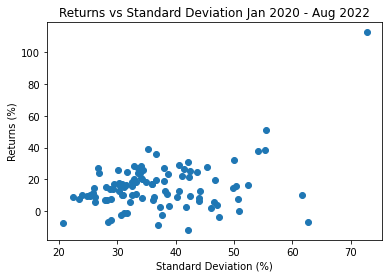

In [17]:
plt.scatter(sd_all, returns_all)
plt.xlabel("Standard Deviation (%)")
plt.ylabel("Returns (%)")
plt.title("Returns vs Standard Deviation Jan 2020 - Aug 2022")

In [18]:
print("The largest outliers for returns were Tesla, NVIDIA, Eli Lilly and Co, Advanced Micro Devices, and ConocoPhillips, which are large technology, pharmaceutical and oil companies that have been performing well.")
outliers_returns_max = returns_all.sort_values(0, ascending = False)
outliers_returns_max.columns=["Top Returns"]
outliers_returns_max.head(5)

The largest outliers for returns were Tesla, NVIDIA, Eli Lilly and Co, Advanced Micro Devices, and ConocoPhillips, which are large technology, pharmaceutical and oil companies that have been performing well.


,Top Returns
TSLA,112.4892
NVDA,50.8194
LLY,38.8965
AMD,38.3120
COP,37.8884


In [19]:
print("the largest outliers for standard deviation were for Tesla, Boeing Co, Simon Propery Group Inc,NVIDIA, and Advanced Micro Devices, which are large technology, airline and real estate companies with large volatilities based on the economy. ")
outliers_sd_max = sd_all.sort_values(0, ascending = False)
outliers_sd_max.columns=["Top Standard Deviation"]
outliers_sd_max.head(5)

the largest outliers for standard deviation were for Tesla, Boeing Co, Simon Propery Group Inc,NVIDIA, and Advanced Micro Devices, which are large technology, airline and real estate companies with large volatilities based on the economy. 


,Top Standard Deviation
TSLA,72.8124
BA,62.7044
SPG,61.6386
NVDA,55.4198
AMD,55.3065


In [20]:
print("The lowest outliers for returns was for Intel, Walgreens Boots Alliance Inc, Verizon, Boeing Co, and AT&T, all companies that have not been performing well.")
outliers_returns_min = returns_all.sort_values(0)
outliers_returns_min.columns=["Bottom Returns"]
outliers_returns_min.head(5)

The lowest outliers for returns was for Intel, Walgreens Boots Alliance Inc, Verizon, Boeing Co, and AT&T, all companies that have not been performing well.


,Bottom Returns
INTC,-11.7462
WBA,-8.3692
VZ,-7.6520
BA,-6.7236
T,-6.5549


In [21]:
print("The lowest outliers for standard deviation were for Verizon,Johnson and Johnson, Bristol-Myers Squibb Co, Colgate, and Proctor and Gamble, all companies with low volatility relative to the performance of the economy.")
outliers_sd_min = sd_all.sort_values(0)
outliers_sd_min.columns=["Bottom Standard Deviation"]
outliers_sd_min.head(5)

The lowest outliers for standard deviation were for Verizon,Johnson and Johnson, Bristol-Myers Squibb Co, Colgate, and Proctor and Gamble, all companies with low volatility relative to the performance of the economy.


,Bottom Standard Deviation
VZ,20.5963
JNJ,22.4284
BMY,23.5012
CL,23.9456
PG,24.7368


# Repeat the exercise above (question 5) with 100 random portfolios of 2, 5, 10, and 25 stocks.

In [22]:
np.random.seed(42)

In [23]:
sample_2_returns = []
for i in range(100):
    sample_2_returns.append(pd.DataFrame(unstack_all.unstack().unstack().unstack().sample(2).mean(axis = 1).mul(252)).mul(100))


In [24]:
sample_2_sd = []
for i in range(100):
    sample_2_sd.append(pd.DataFrame(unstack_all.unstack().unstack().unstack().sample(2).std(axis = 1).mul(np.sqrt(252))).mul(100))

Text(0.5, 1.0, 'Returns vs Standard Deviation 100 2-Ticker Portfolios Jan 2020 - Aug 2022')

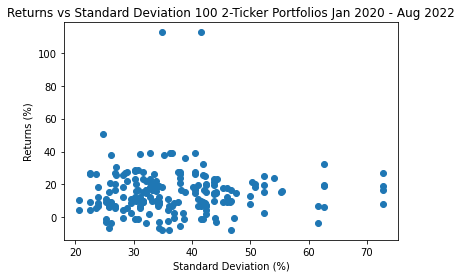

In [25]:
plt.scatter(sample_2_sd, sample_2_returns)
plt.xlabel("Standard Deviation (%)")
plt.ylabel("Returns (%)")
plt.title("Returns vs Standard Deviation 100 2-Ticker Portfolios Jan 2020 - Aug 2022")

In [26]:
sample_5_returns = []
for i in range(100):
    sample_5_returns.append(pd.DataFrame(unstack_all.unstack().unstack().unstack().sample(5).mean(axis=1).mul(252)).mul(100))

In [27]:
sample_5_sd = []
for i in range(100):
    sample_5_sd.append(pd.DataFrame(unstack_all.unstack().unstack().unstack().sample(5).std(axis = 1).mul(np.sqrt(252))).mul(100))

Text(0.5, 1.0, 'Returns vs Standard Deviation 100 5-Ticker Portfolios Jan 2020 - Aug 2022')

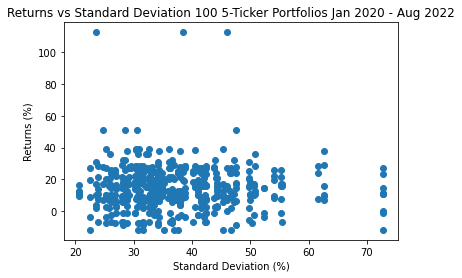

In [28]:
plt.scatter(sample_5_sd, sample_5_returns)
plt.xlabel("Standard Deviation (%)")
plt.ylabel("Returns (%)")
plt.title("Returns vs Standard Deviation 100 5-Ticker Portfolios Jan 2020 - Aug 2022")

In [29]:
sample_10_returns = []
for i in range(100):
    sample_10_returns.append(pd.DataFrame(unstack_all.unstack().unstack().unstack().sample(10).mean(axis=1).mul(252)).mul(100))

In [30]:
sample_10_sd = []
for i in range(100):
    sample_10_sd.append(pd.DataFrame(unstack_all.unstack().unstack().unstack().sample(10).std(axis = 1).mul(np.sqrt(252))).mul(100))

Text(0.5, 1.0, 'Returns vs Standard Deviation 100 10-Ticker Portfolios Jan 2020 - Aug 2022')

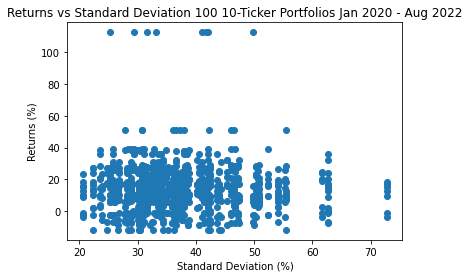

In [31]:
plt.scatter(sample_10_sd, sample_10_returns)
plt.xlabel("Standard Deviation (%)")
plt.ylabel("Returns (%)")
plt.title("Returns vs Standard Deviation 100 10-Ticker Portfolios Jan 2020 - Aug 2022")

In [32]:
sample_25_returns = []
for i in range(100):
    sample_25_returns.append(pd.DataFrame(unstack_all.unstack().unstack().unstack().sample(25).mean(axis=1).mul(252)).mul(100))

In [33]:
sample_25_sd = []
for i in range(100):
    sample_25_sd.append(pd.DataFrame(unstack_all.unstack().unstack().unstack().sample(25).std(axis = 1).mul(np.sqrt(252))).mul(100))

Text(0.5, 1.0, 'Returns vs Standard Deviation 100 25-Ticker Portfolios Jan 2020 - Aug 2022')

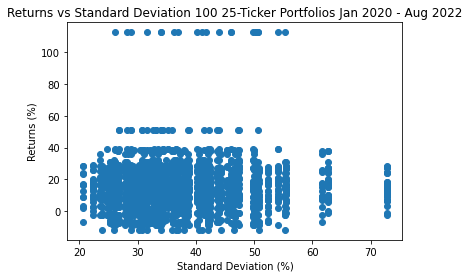

In [34]:
plt.scatter(sample_25_sd, sample_25_returns)
plt.xlabel("Standard Deviation (%)")
plt.ylabel("Returns (%)")
plt.title("Returns vs Standard Deviation 100 25-Ticker Portfolios Jan 2020 - Aug 2022")